#### Описание признаков в таблице

- `match_id`: идентификатор матча в наборе данных
- `start_time`: время начала матча (unixtime)
- `lobby_type`: тип комнаты, в которой собираются игроки (расшифровка в `dictionaries/lobbies.csv`)
- Наборы признаков для каждого игрока (игроки команды Radiant — префикс `rN`, Dire — `dN`):
    - `r1_hero`: герой игрока (расшифровка в dictionaries/heroes.csv)
    - `r1_level`: максимальный достигнутый уровень героя (за первые 5 игровых минут)
    - `r1_xp`: максимальный полученный опыт
    - `r1_gold`: достигнутая ценность героя
    - `r1_lh`: число убитых юнитов
    - `r1_kills`: число убитых игроков
    - `r1_deaths`: число смертей героя
    - `r1_items`: число купленных предметов
- Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_tpscroll_count`: число предметов "tpscroll" за первые 5 минут
    - `radiant_boots_count`: число предметов "boots"
    - `radiant_ward_observer_count`: число предметов "ward_observer"
    - `radiant_ward_sentry_count`: число предметов "ward_sentry"
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля
- Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
    - `duration`: длительность
    - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
    - Состояние башен и барраков к концу матча (см. описание полей набора данных)
        - `tower_status_radiant`
        - `tower_status_dire`
        - `barracks_status_radiant`
        - `barracks_status_dire`

In [33]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

df_train = pd.read_csv('./features.csv', index_col='match_id')
y = df_train['radiant_win']
cv = KFold(n_splits=5, shuffle=True)
# Удалим признаки, связанные с итогами матча (6 штук)
df_train = df_train.iloc[:, :-6]
num_obj = len(df_train)
num_feat = len(df_train.columns)
df_train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0


### Проверим данные на наличие пропусков

In [34]:
missed_values = np.zeros(num_feat)
for ii in range(num_feat):
    missed_values[ii] = num_obj-df_train[df_train.columns[ii]].count()
# Выведем названия признаков, в которых есть пропуски
col_miss = df_train.columns[np.nonzero(missed_values)]
col_miss_df = pd.DataFrame(
    {'missed_values' : np.int64(missed_values[np.nonzero(missed_values)])}, 
    index=col_miss)

# Заменим пропуски на нули
df_train = df_train.fillna(0)
# Для удобства 
X = df_train

### Признаки, связанные с пролитием "первой крови" (**first_blood_time**, **first_blood_team**, **first_blood_player1**, **first_blood_player2**) могут иметь пропуски, если не было убийств в первые 5 минут.
### **radiant_bottle_time**, **radiant_courier_time**, **radiant_flying_courier_time** -- если не были куплены соответствующие предметы.
### **radiant_first_ward_time** -- если не был установлен вард.
### Аналогично для стороны "Dire".

## Подход 1: градиентный бустинг

In [35]:
# Протестируем для разного количества деревьев
num_est = [10, 30, 50, 100, 200]
cv_mean_score1 = []
time_spent = []
for ii in range(len(num_est)):
    tic = time()
    clf = GradientBoostingClassifier(n_estimators=num_est[ii])
    clf.fit(X, y)
    # Найдем оценку на кросс-валидации
    cv_mean_score1.append(np.mean(cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')))
    toc = time()
    time_spent.append(toc-tic) 
    print('Количество деревьев: %g, затраченное время: %g мин., %g сек., AUC-ROC = %3f\n' % 
                        (num_est[ii], (toc-tic)//60, (toc-tic)%60, cv_mean_score1[-1]))

Количество деревьев: 10, затраченное время: 2 мин., 1.33315 сек., AUC-ROC = 0.664699

Количество деревьев: 30, затраченное время: 6 мин., 1.86357 сек., AUC-ROC = 0.689550

Количество деревьев: 50, затраченное время: 10 мин., 1.51751 сек., AUC-ROC = 0.697918

Количество деревьев: 100, затраченное время: 20 мин., 0.671525 сек., AUC-ROC = 0.706332

Количество деревьев: 200, затраченное время: 39 мин., 34.5687 сек., AUC-ROC = 0.713576



### Графики оценки кросс-валидации и затраченного времени

Text(0, 0.5, 'Время моделирования, сек')

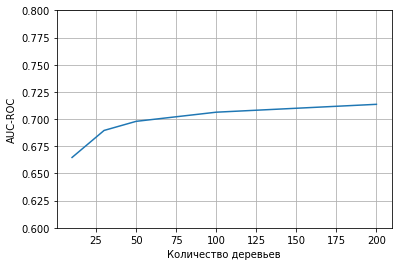

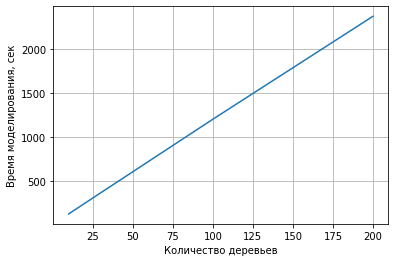

In [36]:
fig1, ax1 = plt.subplots()
ax1.grid(True)
ax1.plot(num_est, cv_mean_score1)
ax1.set_xlabel('Количество деревьев')
ax1.set_ylabel('AUC-ROC')
ax1.set_ylim([0.6, 0.8])

fig2, ax2 = plt.subplots()
ax2.grid(True)
ax2.plot(num_est, time_spent)
ax2.set_xlabel('Количество деревьев')
ax2.set_ylabel('Время моделирования, сек')

### При увеличении количества деревьев до 50, 100, 200 качество растет до значение 0.71-0.72, однако время кросс-валидации также заметно растет. Ускорения можно достичь, например, если использовать для обучения не всю выборку и/или уменьшить глубину деревьев

## Подход 2: логистическая регрессия

In [37]:
C_regul = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
cv_mean_score2 = []
# Отмасштабируем
scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), index=X.index, columns=X.columns)

for regul in C_regul:
    clf = LogisticRegression(penalty='l2', C=regul, max_iter=200).fit(X, y)
    cv_mean_score2.append(np.mean(cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')))
    print('C = %g, score = %3f\n' % (regul, cv_mean_score2[-1]))

C = 1e-07, score = 0.687162

C = 1e-06, score = 0.688173

C = 1e-05, score = 0.695078

C = 0.0001, score = 0.711207

C = 0.001, score = 0.716400

C = 0.01, score = 0.716242

C = 0.1, score = 0.716489



(0.65, 0.75)

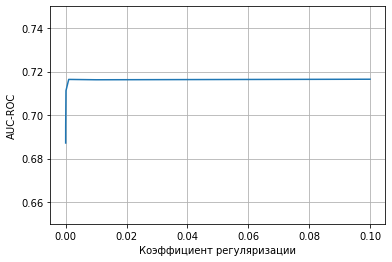

In [38]:
fig1, ax1 = plt.subplots()
ax1.grid(True)
ax1.plot(C_regul, cv_mean_score2)
ax1.set_xlabel('Коэффициент регуляризации')
ax1.set_ylabel('AUC-ROC')
ax1.set_ylim([0.65, 0.75])

### При C = 0.01 качество перестает заметно расти

### Уберем категориальные признаки и проверим качество снова

In [39]:
# Список категориальных признаков
categ_feat = ['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero',  'r4_hero', 'r5_hero',
              'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']
X_nocateg = X.drop(categ_feat, axis=1, inplace=False)
# Также проведем исследование
C_regul = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
cv_mean_score3 = []

for regul in C_regul:
    clf = LogisticRegression(penalty='l2', C=regul, max_iter=200).fit(X_nocateg, y)
    cv_mean_score3.append(np.mean(cross_val_score(clf, X_nocateg, y, cv=cv, scoring='roc_auc')))
    print('C = %g, score = %3f\n' % (regul, cv_mean_score3[-1]))

C = 1e-07, score = 0.687216

C = 1e-06, score = 0.688086

C = 1e-05, score = 0.695074

C = 0.0001, score = 0.711234

C = 0.001, score = 0.716228

C = 0.01, score = 0.716403

C = 0.1, score = 0.716345



(0.65, 0.75)

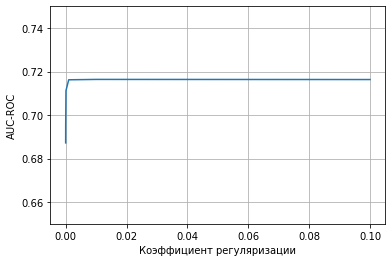

In [40]:
fig1, ax1 = plt.subplots()
ax1.grid(True)
ax1.plot(C_regul, cv_mean_score3)
ax1.set_xlabel('Коэффициент регуляризации')
ax1.set_ylabel('AUC-ROC')
ax1.set_ylim([0.65, 0.75])

### Удаление категориальных признаков не привело к улучшению или ухудшению качества. Получается, эти признаки не вносили вклад в результат, хотя, например, выбранный персонаж играет значительную роль в игре (существуют просто сильнейшие персонажи в текущей "мете", одни герои хорошо стоят линию против других и т.д.) Можно сделать вывод, что имеющаяся информация была неправильно использована для предсказания.

### Найдем количество персонажей

In [41]:
num_heroes = 0
for ii in range(10):
    if ii <= 4:
        max_id = df_train['r'+str(ii+1)+'_hero'].max()
    else:
        max_id = df_train['d'+str(ii-4)+'_hero'].max()
if max_id > num_heroes:
    num_heroes = max_id

print('%d героев в игре' % num_heroes)

112 героев в игре


### Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire

In [42]:
X_pick = np.zeros((X.shape[0], num_heroes))
for ii, match_id in enumerate(X.index):
    for jj in range(5):
        X_pick[ii, df_train['r%d_hero' % (jj+1)][match_id]-1] = 1
        X_pick[ii, df_train['d%d_hero' % (jj+1)][match_id]-1] = -1
# Добавим новые признаки
X_pick = pd.DataFrame(data=X_pick, index=X.index)    
X_train = pd.concat([X_nocateg, X_pick], axis=1)

### Проведем кросс-валидацию для логистической регрессии на новых данных

In [43]:
C_regul = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
cv_mean_score4 = []

for regul in C_regul:
    clf = LogisticRegression(penalty='l2', C=regul, max_iter=200).fit(X_train, y)
    cv_mean_score4.append(np.mean(cross_val_score(clf, X_train, y, cv=cv, scoring='roc_auc')))
    print('C = %g, score = %3f\n' % (regul, cv_mean_score4[-1]))

C = 1e-07, score = 0.689413

C = 1e-06, score = 0.690477

C = 1e-05, score = 0.699112

C = 0.0001, score = 0.724982

C = 0.001, score = 0.746140

C = 0.01, score = 0.751783

C = 0.1, score = 0.751757



(0.65, 0.8)

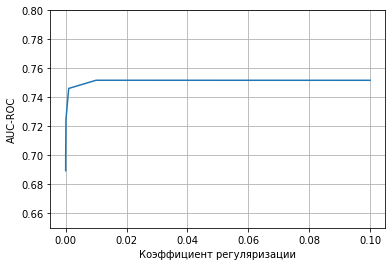

In [44]:
fig1, ax1 = plt.subplots()
ax1.grid(True)
ax1.plot(C_regul, cv_mean_score4)
ax1.set_xlabel('Коэффициент регуляризации')
ax1.set_ylabel('AUC-ROC')
ax1.set_ylim([0.65, 0.8])

### AUC-ROC = 0.7516 при C = 0.01. Улучшение объясняется тем, что категориальные признаки были правильно закодированы (до этого категориальные признаки рассматривались как числовые)

### Предсказание победителя на тестовых данных с использованием лучшей модели
### Предобработка тестовых данных

In [45]:
df_test = pd.read_csv('features_test.csv', index_col='match_id')
df_test.head()

X_test = df_test
# Заменим пропуски на нули
X_test = X_test.fillna(0)
X_test = X_test.drop(categ_feat, axis=1, inplace=False)
X_test = pd.DataFrame(data=scaler.fit_transform(X_test), index=X_test.index, columns=X_test.columns)
# Формируем новые признаки
X_pick = np.zeros((X_test.shape[0], num_heroes))
for ii, match_id in enumerate(X_test.index):
    for jj in range(5):
        X_pick[ii, df_test['r%d_hero' % (jj+1)][match_id]-1] = 1
        X_pick[ii, df_test['d%d_hero' % (jj+1)][match_id]-1] = -1
# Добавим новые признаки
X_pick = pd.DataFrame(data=X_pick, index=X_test.index)    
X_test = pd.concat([X_test, X_pick], axis=1)

### Предсказание

In [46]:
clf = LogisticRegression(penalty='l2', C=0.1, max_iter=200).fit(X_train, y)
result = pd.Series(data=clf.predict_proba(X_test)[:, 1], index=X_test.index, name='radiant_win')
result.to_csv('result.csv')
# Минимальное и максимальное значения прогноза
print('Максимальное значение прогноза: %3f\nМинимальное значение прогноза: %3f' % (result.max(), result.min()))

Максимальное значение прогноза: 0.996460
Минимальное значение прогноза: 0.008577
